In [1]:
import pandas as pd
import numpy as np
from enum import Enum
import pytz
from datetime import datetime, time

from backtesting import Backtest, Strategy
from backtesting import set_bokeh_output
set_bokeh_output(notebook=False)

import warnings
warnings.filterwarnings("ignore")

C:\mypythonenvironments\.venv_tech_analysis_and_backtesting\Lib\site-packages\backtesting\_plotting.py:53: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

C:\mypythonenvironments\.venv_tech_analysis_and_backtesting\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('EURUSD_M1.csv', delimiter='\t')
df.rename(columns={'<DATE>': 'date', '<TIME>': 'time', '<OPEN>': 'Open', '<HIGH>': 'High', '<LOW>': 'Low', '<CLOSE>':'Close', '<TICKVOL>':'tick_volume', '<VOL>':'volume', '<SPREAD>': 'spread'}, inplace=True)
# Combine 'date' and 'time' columns into a single datetime column
df['time'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df['time'] = df['time'].dt.tz_localize('GMT')
# Set the new datetime column as the index
df.set_index('time', inplace=True)
# Drop the original 'date' and 'time' columns
df.drop(columns=['date','tick_volume','spread','volume'], inplace=True)
df

,Open,High,Low,Close
time,,,,
2024-04-01 00:00:00+00:00,1.07870,1.07870,1.07870,1.07870
2024-04-01 00:01:00+00:00,1.07865,1.07865,1.07865,1.07865
2024-04-01 00:02:00+00:00,1.07865,1.07888,1.07865,1.07888
2024-04-01 00:03:00+00:00,1.07888,1.07891,1.07888,1.07891
2024-04-01 00:04:00+00:00,1.07891,1.07891,1.07891,1.07891
...,...,...,...,...
2025-02-10 06:05:00+00:00,1.03128,1.03131,1.03124,1.03127
2025-02-10 06:06:00+00:00,1.03128,1.03139,1.03127,1.03138
2025-02-10 06:07:00+00:00,1.03138,1.03145,1.03138,1.03143


In [3]:
# Create an enum for the forex markets
class ForexMarket(Enum):
    LONDON = "London"
    TOKYO = "Tokyo"
    SYDNEY = "Sydney"
    NEW_YORK = "New York"

# Function to check if a market is open
def is_market_open(market: ForexMarket, gmt_time: datetime) -> bool:

    # Ensure gmt_time is timezone-aware
    if gmt_time.tzinfo is None:  # If it's a naive datetime
        gmt_time = pytz.UTC.localize(gmt_time)

    # Define DST start and end dates in UTC
    dst_start = datetime(gmt_time.year, 3, 31 - (datetime(gmt_time.year, 3, 31).weekday() + 1) % 7, 1, tzinfo=pytz.UTC)
    dst_end = datetime(gmt_time.year, 10, 31 - (datetime(gmt_time.year, 10, 31).weekday() + 1) % 7, 1, tzinfo=pytz.UTC)

    # Define market hours in GMT depending on DST
    if dst_start <= gmt_time < dst_end:
        # SUMMER TIME
        market_hours = {
            ForexMarket.LONDON: (time(7, 0), time(16, 0)),  # 8 AM to 5 PM GMT
            ForexMarket.TOKYO: (time(23, 0), time(8, 0)),    # Midnight to 9 AM GMT
            ForexMarket.SYDNEY: (time(22, 0), time(7, 0)),  # 10 PM to 7 AM GMT (overnight)
            ForexMarket.NEW_YORK: (time(12, 0), time(21, 0)) # 1 PM to 10 PM GMT
        }
    else:
        # WINTER TIME
        market_hours = {
            ForexMarket.LONDON: (time(8, 0), time(17, 0)),  # 8 AM to 5 PM GMT
            ForexMarket.TOKYO: (time(0, 0), time(9, 0)),    # Midnight to 9 AM GMT
            ForexMarket.SYDNEY: (time(21, 0), time(6, 0)),  # 10 PM to 7 AM GMT (overnight)
            ForexMarket.NEW_YORK: (time(13, 0), time(22, 0)) # 1 PM to 10 PM GMT
        }

    # Check if it's a weekend
    if gmt_time.weekday() >= 5:  # Saturday or Sunday
        return False
    # Get the market's open and close times
    open_time, close_time = market_hours[market]

    # Handle markets with overnight hours (e.g., Sydney)
    if open_time < close_time:
        return open_time <= gmt_time.time() < close_time
    else:
        return gmt_time.time() >= open_time or gmt_time.time() < close_time

# Create boolean columns for each Forex market
df['LondonOpen'] = df.index.map(lambda x: is_market_open(ForexMarket.LONDON, x))
df['TokyoOpen'] = df.index.map(lambda x: is_market_open(ForexMarket.TOKYO, x))
df['SydneyOpen'] = df.index.map(lambda x: is_market_open(ForexMarket.SYDNEY, x))
df['NewYorkOpen'] = df.index.map(lambda x: is_market_open(ForexMarket.NEW_YORK, x))
# Asian Session is considered Tokyo and Sydney
df['AsiaOpen'] = df['TokyoOpen'] | df['SydneyOpen']
# In our case we will need the Asia Open but excluding London
df['AsiaOpen'] = df['AsiaOpen'] & ~df['LondonOpen']
df

,Open,High,Low,Close,LondonOpen,TokyoOpen,SydneyOpen,NewYorkOpen,AsiaOpen
time,,,,,,,,,
2024-04-01 00:00:00+00:00,1.07870,1.07870,1.07870,1.07870,False,True,True,False,True
2024-04-01 00:01:00+00:00,1.07865,1.07865,1.07865,1.07865,False,True,True,False,True
2024-04-01 00:02:00+00:00,1.07865,1.07888,1.07865,1.07888,False,True,True,False,True
2024-04-01 00:03:00+00:00,1.07888,1.07891,1.07888,1.07891,False,True,True,False,True
2024-04-01 00:04:00+00:00,1.07891,1.07891,1.07891,1.07891,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...
2025-02-10 06:05:00+00:00,1.03128,1.03131,1.03124,1.03127,False,True,False,False,True
2025-02-10 06:06:00+00:00,1.03128,1.03139,1.03127,1.03138,False,True,False,False,True
2025-02-10 06:07:00+00:00,1.03138,1.03145,1.03138,1.03143,False,True,False,False,True


In [4]:
# Function to compute continuous True indices
def identity_market_sessions(df, boolean_column):
    continuous_true = []
    current_index = None

    for index, value in df[boolean_column].items():  # Use items() instead of iteritems()
        if value:  # If the value is True
            if current_index is None:  # Start of a new group
                current_index = index
            continuous_true.append(current_index)
        else:  # Reset for False values
            current_index = None
            continuous_true.append(None)

    return continuous_true

# Add the new column to the DataFrame
df['TokyoSession'] = identity_market_sessions(df, 'TokyoOpen')
df['SydneySession'] = identity_market_sessions(df, 'SydneyOpen')
df['NewYorkSession'] = identity_market_sessions(df, 'NewYorkOpen')
df['AsianSession'] = identity_market_sessions(df, 'AsiaOpen')
df['LondonSession'] = identity_market_sessions(df, 'LondonOpen')
df

,Open,High,Low,Close,LondonOpen,TokyoOpen,SydneyOpen,NewYorkOpen,AsiaOpen,TokyoSession,SydneySession,NewYorkSession,AsianSession,LondonSession
time,,,,,,,,,,,,,,
2024-04-01 00:00:00+00:00,1.07870,1.07870,1.07870,1.07870,False,True,True,False,True,2024-04-01 00:00:00+00:00,2024-04-01 00:00:00+00:00,NaT,2024-04-01 00:00:00+00:00,NaT
2024-04-01 00:01:00+00:00,1.07865,1.07865,1.07865,1.07865,False,True,True,False,True,2024-04-01 00:00:00+00:00,2024-04-01 00:00:00+00:00,NaT,2024-04-01 00:00:00+00:00,NaT
2024-04-01 00:02:00+00:00,1.07865,1.07888,1.07865,1.07888,False,True,True,False,True,2024-04-01 00:00:00+00:00,2024-04-01 00:00:00+00:00,NaT,2024-04-01 00:00:00+00:00,NaT
2024-04-01 00:03:00+00:00,1.07888,1.07891,1.07888,1.07891,False,True,True,False,True,2024-04-01 00:00:00+00:00,2024-04-01 00:00:00+00:00,NaT,2024-04-01 00:00:00+00:00,NaT
2024-04-01 00:04:00+00:00,1.07891,1.07891,1.07891,1.07891,False,True,True,False,True,2024-04-01 00:00:00+00:00,2024-04-01 00:00:00+00:00,NaT,2024-04-01 00:00:00+00:00,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 06:05:00+00:00,1.03128,1.03131,1.03124,1.03127,False,True,False,False,True,2025-02-10 00:00:00+00:00,NaT,NaT,2025-02-07 21:00:00+00:00,NaT
2025-02-10 06:06:00+00:00,1.03128,1.03139,1.03127,1.03138,False,True,False,False,True,2025-02-10 00:00:00+00:00,NaT,NaT,2025-02-07 21:00:00+00:00,NaT
2025-02-10 06:07:00+00:00,1.03138,1.03145,1.03138,1.03143,False,True,False,False,True,2025-02-10 00:00:00+00:00,NaT,NaT,2025-02-07 21:00:00+00:00,NaT


In [5]:
# I am grouping at the Asian Session to get the highs and lows,
# then I forward fill the values till the next session so i have this information when Asia is closed
# For safety I keep those values only for Asia and London for this strategy
df['HighAsianSession'] = df.groupby('AsianSession')['High'].transform('max').where(df['AsiaOpen'])
df["HighAsianSession"] = df["HighAsianSession"].fillna(method='ffill')
df.loc[(df["LondonOpen"] == False) & (df["AsiaOpen"] == False), "HighAsianSession"] = np.nan
df['LowAsianSession'] = df.groupby('AsianSession')['Low'].transform('min').where(df['AsiaOpen'])
df['LowAsianSession'] = df["LowAsianSession"].fillna(method='ffill')
df.loc[(df["LondonOpen"] == False) & (df["AsiaOpen"] == False), "LowAsianSession"] = np.nan
df

,Open,High,Low,Close,LondonOpen,TokyoOpen,SydneyOpen,NewYorkOpen,AsiaOpen,TokyoSession,SydneySession,NewYorkSession,AsianSession,LondonSession,HighAsianSession,LowAsianSession
time,,,,,,,,,,,,,,,,
2024-04-01 00:00:00+00:00,1.07870,1.07870,1.07870,1.07870,False,True,True,False,True,2024-04-01 00:00:00+00:00,2024-04-01 00:00:00+00:00,NaT,2024-04-01 00:00:00+00:00,NaT,1.07987,1.07841
2024-04-01 00:01:00+00:00,1.07865,1.07865,1.07865,1.07865,False,True,True,False,True,2024-04-01 00:00:00+00:00,2024-04-01 00:00:00+00:00,NaT,2024-04-01 00:00:00+00:00,NaT,1.07987,1.07841
2024-04-01 00:02:00+00:00,1.07865,1.07888,1.07865,1.07888,False,True,True,False,True,2024-04-01 00:00:00+00:00,2024-04-01 00:00:00+00:00,NaT,2024-04-01 00:00:00+00:00,NaT,1.07987,1.07841
2024-04-01 00:03:00+00:00,1.07888,1.07891,1.07888,1.07891,False,True,True,False,True,2024-04-01 00:00:00+00:00,2024-04-01 00:00:00+00:00,NaT,2024-04-01 00:00:00+00:00,NaT,1.07987,1.07841
2024-04-01 00:04:00+00:00,1.07891,1.07891,1.07891,1.07891,False,True,True,False,True,2024-04-01 00:00:00+00:00,2024-04-01 00:00:00+00:00,NaT,2024-04-01 00:00:00+00:00,NaT,1.07987,1.07841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 06:05:00+00:00,1.03128,1.03131,1.03124,1.03127,False,True,False,False,True,2025-02-10 00:00:00+00:00,NaT,NaT,2025-02-07 21:00:00+00:00,NaT,1.03382,1.02779
2025-02-10 06:06:00+00:00,1.03128,1.03139,1.03127,1.03138,False,True,False,False,True,2025-02-10 00:00:00+00:00,NaT,NaT,2025-02-07 21:00:00+00:00,NaT,1.03382,1.02779
2025-02-10 06:07:00+00:00,1.03138,1.03145,1.03138,1.03143,False,True,False,False,True,2025-02-10 00:00:00+00:00,NaT,NaT,2025-02-07 21:00:00+00:00,NaT,1.03382,1.02779


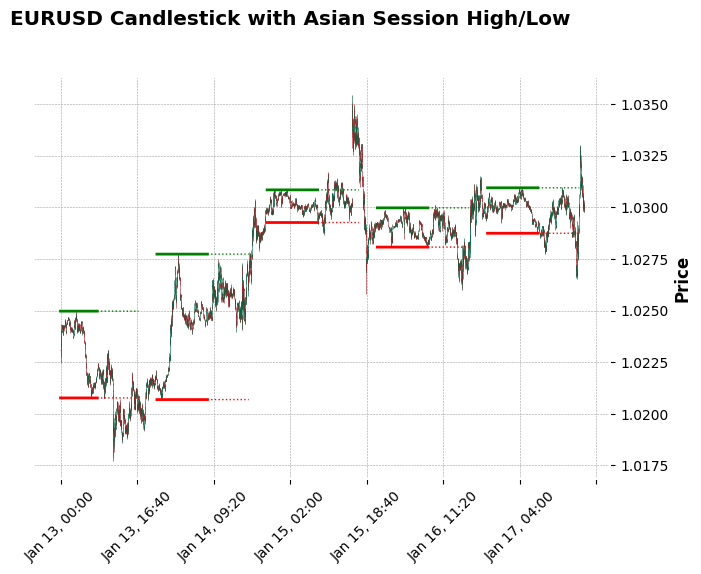

In [6]:
import mplfinance as mpf
import matplotlib.pyplot as plt

# Define start and end datetimes
start_datetime = pd.to_datetime('2025-01-13 00:00:00').tz_localize('GMT')
end_datetime = pd.to_datetime('2025-01-17 18:00:00').tz_localize('GMT')
data = df.loc[start_datetime:end_datetime].copy()


# Prepare the data for mplfinance
mpf_data = data[['Open', 'High', 'Low', 'Close']]


high_asian = data.loc[data['AsiaOpen'], 'HighAsianSession'].astype(float)

low_asian = data[data['AsiaOpen']]['LowAsianSession'].dropna().astype(float)
high_asian_during_London = data[data['LondonOpen']]['HighAsianSession'].dropna().astype(float)
low_asian_during_London = data[data['LondonOpen']]['LowAsianSession'].dropna().astype(float)

# Ensure indices match between additional plots and candlestick data, leaving unmatched as null
high_asian = high_asian.reindex(mpf_data.index)
low_asian = low_asian.reindex(mpf_data.index)
high_asian_during_London = high_asian_during_London.reindex(mpf_data.index)
low_asian_during_London = low_asian_during_London.reindex(mpf_data.index)

# # Create additional lines for HighAsianSession and LowAsianSession
add_plots = [
    mpf.make_addplot(high_asian, color='green', linestyle='-', width=2),
    mpf.make_addplot(low_asian, color='red', linestyle='-', width=2),
    mpf.make_addplot(high_asian_during_London, color='green', linestyle=':', width=1),
    mpf.make_addplot(low_asian_during_London, color='red', linestyle=':', width=1)
]

# Plot the candlestick chart with additional lines
mpf.plot(mpf_data, type='candle', style='charles', addplot=add_plots,
         title='EURUSD Candlestick with Asian Session High/Low',
         ylabel='Price', volume=False)

plt.show()

In [7]:
def calculate_pip_difference(from_rate, to_rate, pip_point = 4):
    # Calculate the pip size based on the pip point
    pip_size = 10 ** -pip_point

    # Calculate the difference in pips
    pip_difference = (to_rate - from_rate) / pip_size
    return pip_difference

def calculate_new_rate(rate, pips, pip_point=4):
    # Calculate the pip size based on the pip point
    pip_size = 10 ** -pip_point

    # Calculate the new rate
    new_rate = rate + (pips * pip_size)
    return new_rate

In [14]:
class LondonBreakOutStrategy(Strategy):

    # # params to optimize
    pivot_high_low_bars = 60
    ratio_profit_loss = 1.4
    total_candles = 0
    # if SL is less than some pips, abort or reset the SL
    min_SL_pips_trade = 25
    set_sl_to_min = True
    # if TP is more than some pips, reset TP or leave as is
    max_TP_pips_trade = 75
    set_tp_to_max = True
    # check Asian Session Range to trade or not
    trade_in_range_of_asian_session = True
    min_asian_session_size = 10
    max_asian_session_size = 50

    # other parameters
    pair_pip_point = 4 # change to 2 if JPY is in the pair
    initial_equity = 0


    def did_not_do_a_trade_today(self):
        if self.position.size != 0:
            return False
        for trade in self.closed_trades:
            if trade.entry_time.date() == self.data.index[-1].date():
                return False
        return True

    def init(self):

        self.total_candles = len(self.data)

    def next(self):

        # ==============================
        # FILTERS
        # ==============================

        filter_ok = True # Will move to False if I should filter out the below

        # Check Asian Session Size and return if needed
        asian_session_size = (self.data.HighAsianSession[-1] - self.data.LowAsianSession[-1]) * (10**self.pair_pip_point)
        if self.trade_in_range_of_asian_session:
            if (asian_session_size < self.min_asian_session_size) or (asian_session_size > self.max_asian_session_size):
                filter_ok = False

        # ==============================
        # TRADE LOGIC
        # ==============================

        if filter_ok and self.position.size == 0:

            # when london session opens and close is above the Asian session high, we buy
            if self.data.LondonSession[-1] and self.data.Close[-1] > self.data.HighAsianSession[-1] and self.position.size == 0 and self.did_not_do_a_trade_today():
                # Identify the last pivot low (minimum within the last bars)
                SL_rate = min(self.data.Low[-self.pivot_high_low_bars:])
                TP_rate = self.data.Close[-1] + self.ratio_profit_loss * (self.data.Close[-1] - SL_rate)

                # calculate pips
                SL_pips = calculate_pip_difference(self.data.Close[-1], SL_rate)
                TP_pips = calculate_pip_difference(self.data.Close[-1], TP_rate)

                # check SL
                if abs(SL_pips) < self.min_SL_pips_trade:
                    # check if abord or set new SL TP
                    if self.set_sl_to_min:
                        SL_rate = calculate_new_rate(self.data.Close[-1],-self.min_SL_pips_trade)
                        TP_rate = self.data.Close[-1] + self.ratio_profit_loss * (self.data.Close[-1] - SL_rate)
                        TP_pips = calculate_pip_difference(self.data.Close[-1], TP_rate)
                    else:
                        pass

                # check TP
                if abs(TP_pips) > self.max_TP_pips_trade:
                    # check if I should change the TP - otherwise leave it as is
                    if self.set_tp_to_max:
                        TP_rate = calculate_new_rate(self.data.Close[-1], self.max_TP_pips_trade)

                try:
                    self.buy(sl=SL_rate, tp=TP_rate)
                except Exception as e:
                    print(e)
                    pass
            elif self.data.LondonSession[-1] and self.data.Close[-1] < self.data.LowAsianSession[-1] and self.position.size == 0 and self.did_not_do_a_trade_today():
                # Identify the last pivot high (maximum within the last bars)
                SL_rate = max(self.data.High[-self.pivot_high_low_bars:])
                TP_rate = self.data.Close[-1] - self.ratio_profit_loss * (SL_rate - self.data.Close[-1])

                # calculate pips
                SL_pips = calculate_pip_difference(self.data.Close[-1], SL_rate)
                TP_pips = calculate_pip_difference(self.data.Close[-1], TP_rate)

                # check SL TP
                if abs(SL_pips) < self.min_SL_pips_trade:
                    # check if abord or set new SL TP
                    if self.set_sl_to_min:
                        SL_rate = calculate_new_rate(self.data.Close[-1],self.min_SL_pips_trade)
                        TP_rate = self.data.Close[-1] - self.ratio_profit_loss * (SL_rate - self.data.Close[-1])
                        TP_pips = calculate_pip_difference(self.data.Close[-1], TP_rate)
                    else:
                        pass

                # check TP
                if abs(TP_pips) > self.max_TP_pips_trade:
                    # check if I should change the TP - otherwise leave it as is
                    if self.set_tp_to_max:
                        TP_rate = calculate_new_rate(self.data.Close[-1], -self.max_TP_pips_trade)

                try:
                    self.sell(sl=SL_rate, tp=TP_rate)
                except Exception as e:
                    print(e)
                    pass

        #check for last candles
        if len(self.data) == self.total_candles:
            # if there is a position close it
            if self.position.size > 0:
                self.position.close()

In [15]:
# run single back test
bt = Backtest(df, LondonBreakOutStrategy, cash=10_000)
stats = bt.run()
print(stats)

Start                     2024-04-01 00:00...
End                       2025-02-10 06:09...
Duration                    315 days 06:09:00
Exposure Time [%]                    45.56185
Equity Final [$]                   10747.4198
Equity Peak [$]                   10810.19735
Return [%]                             7.4742
Buy & Hold Return [%]                -4.39418
Return (Ann.) [%]                     8.01625
Volatility (Ann.) [%]                 4.34506
CAGR [%]                              5.93099
Sharpe Ratio                          1.84491
Sortino Ratio                         3.16134
Calmar Ratio                          4.65741
Max. Drawdown [%]                    -1.72118
Avg. Drawdown [%]                    -0.07471
Max. Drawdown Duration       59 days 20:01:00
Avg. Drawdown Duration        0 days 16:17:00
# Trades                                  165
Win Rate [%]                         49.09091
Best Trade [%]                        0.69025
Worst Trade [%]                   

In [10]:
bt.plot()

GridPlot(id='p1271', ...)